In [15]:
!pip install tableone


Import libraries and data

In [16]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

df = pd.read_csv("ResearchInformation3.csv")

for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

# Treatment
df["T"] = df["Job"].map({"Yes": 1, "No": 0}).astype(int)

# Outcome
Y = df["Overall"].astype(float).values
T = df["T"].values

# Confounders (pre-treatment) — מותאם לעמודות שיש לך בדאטה
covariates = [
    "SSC", "HSC", "Last",
    "Income", "Semester",
    "Gender", "Department", "Hometown",
    "Computer", "English"
]
X = df[covariates].copy()


### Pre proccessing

In [17]:
def make_outcome_model_from_df(X_df, alpha=1.0):
    num_cols = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]
    cat_cols = [c for c in X_df.columns if c not in num_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ],
        remainder="drop"
    )

    return Pipeline([
        ("prep", preprocess),
        ("model", Ridge(alpha=alpha))
    ])


## IPW

In [18]:
# ----- Propensity score -----
ps_model = Pipeline([
    ("prep", ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        ]
    )),
    ("logit", LogisticRegression(max_iter=2000))
])

ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]
ps = np.clip(ps, 1e-3, 1 - 1e-3)

# Stabilized IPW weights
p = T.mean()
weights = np.where(T == 1, p / ps, (1 - p) / (1 - ps))

# Weighted regression
X_reg = sm.add_constant(T)
wls = sm.WLS(Y, X_reg, weights=weights).fit()
ate_ipw = wls.params[1]

print("\nIPW ATE:", ate_ipw)


NameError: name 'num_cols' is not defined

### S learner

In [ ]:
Xs = X.copy()
Xs["T"] = T  

s_model = make_outcome_model_from_df(Xs, alpha=1.0)
s_model.fit(Xs, Y)

X1 = Xs.copy(); X1["T"] = 1
X0 = Xs.copy(); X0["T"] = 0

Y1_hat = s_model.predict(X1)
Y0_hat = s_model.predict(X0)

ate_s = float(np.mean(Y1_hat - Y0_hat))
print("S-learner ATE:", ate_s)


S-learner ATE: 0.021947109748995892


### T learner

In [ ]:
model_t = make_outcome_model(X)
model_c = make_outcome_model(X)

model_t.fit(X[T == 1], Y[T == 1])
model_c.fit(X[T == 0], Y[T == 0])

ate_t = np.mean(model_t.predict(X) - model_c.predict(X))
print("T-learner ATE:", ate_t)


T-learner ATE: 0.011277038602807586


###  Bootstrap CI for each model

In [ ]:
def bootstrap_s_learner(df, covariates, B=300, seed=0):
    rng = np.random.default_rng(seed)
    ates = []

    for _ in range(B):
        sample = df.sample(frac=1, replace=True, random_state=int(rng.integers(1e9)))

        Xb = sample[covariates].copy()
        Tb = sample["T"].values
        Yb = sample["Overall"].astype(float).values

        Xsb = Xb.copy()
        Xsb["T"] = Tb

        m = make_outcome_model_from_df(Xsb, alpha=1.0)
        m.fit(Xsb, Yb)

        X1 = Xsb.copy(); X1["T"] = 1
        X0 = Xsb.copy(); X0["T"] = 0

        ates.append(np.mean(m.predict(X1) - m.predict(X0)))

    return np.percentile(ates, [2.5, 50, 97.5])

print("Bootstrap CI S-learner:", bootstrap_s_learner(df, covariates, B=300, seed=1))


Bootstrap CI S-learner: [-0.09205779  0.02638363  0.16163106]


In [ ]:
def bootstrap_t_learner(df, covariates, B=300, seed=0):
    rng = np.random.default_rng(seed)
    ates = []

    for _ in range(B):
        # Bootstrap sample
        sample = df.sample(
            frac=1,
            replace=True,
            random_state=int(rng.integers(1e9))
        )

        Xb = sample[covariates].copy()
        Tb = sample["T"].values
        Yb = sample["Overall"].astype(float).values

        if (Tb == 1).sum() < 5 or (Tb == 0).sum() < 5:
            continue

        model_t = make_outcome_model_from_df(Xb, alpha=1.0)
        model_c = make_outcome_model_from_df(Xb, alpha=1.0)

        model_t.fit(Xb[Tb == 1], Yb[Tb == 1])
        model_c.fit(Xb[Tb == 0], Yb[Tb == 0])

        # Counterfactual predictions
        Y1_hat = model_t.predict(Xb)
        Y0_hat = model_c.predict(Xb)

        ates.append(np.mean(Y1_hat - Y0_hat))

    return np.percentile(ates, [2.5, 50, 97.5])


In [ ]:
ci_t = bootstrap_t_learner(
    df,
    covariates=covariates,
    B=300,
    seed=1
)

print("Bootstrap CI T-learner:", ci_t)


Bootstrap CI T-learner: [-1.88358495e-01  4.15222268e-05  1.77385732e-01]


### Plots


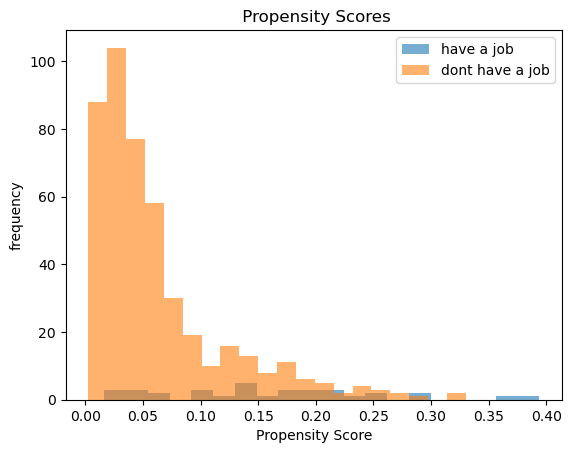

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ps[T==1], bins=20, alpha=0.6, label="have a job")
plt.hist(ps[T==0], bins=20, alpha=0.6, label="dont have a job")
plt.xlabel("Propensity Score")
plt.ylabel("frequency")
plt.legend()
plt.title(" Propensity Scores")
plt.show()


In [ ]:
plt.hist(ates, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Bootstrap distribution of ATE")
plt.xlabel("ATE")
plt.show()

NameError: name 'ates' is not defined